In [27]:
import os
import gzip
import pandas as pd

# reading gene list
engs_gene_df = pd.read_csv('matched-gene-list.tsv', sep='\t', usecols=[0, 1])
engs_gene_df.columns = ['gene', 'id']

# reading TCGA files
df = pd.DataFrame()
source_filename = 'gdc_download_20200211_235941.906086'
for root, dirs, files in os.walk(source_filename, topdown = False):
        
    gz_file = [i for i in files if i.endswith('.gz')]
    if not gz_file:
        # print(root, dirs, files)
        continue
    else:
        gz_file = gz_file[0]
        
    for gz in [i for i in files if i.endswith('.gz')]:    
        with gzip.open(os.path.join(root, gz)) as f:

            temp_df = pd.read_csv(f, sep='\t', names=['id_init', 'count'])
            temp_df['id'] = temp_df['id_init'].apply(lambda x: x.split('.')[0])
            temp_df['file_id'] = os.path.split(root)[-1]
            temp_df = temp_df.merge(engs_gene_df, how='inner', on='id')
            if len(temp_df) == 1:
                continue

            df = pd.concat([df, temp_df], axis=0)
    # break
    # print(temp_df.sample())

In [28]:
# metadata_df = pd.read_json('metadata.cart.2020-02-12.json')
# df = df.merge(metadata_df[['associated_entities', 'file_id']], how='inner', on='file_id')

In [29]:
# including project information
sample_df = pd.read_csv('gdc_sample_sheet.2020-02-12.tsv', sep='\t')
sample_df.columns = [i.lower().replace(' ', '_') for i in list(sample_df)]
df = df.merge(sample_df[['project_id', 'case_id', 'sample_id', 'sample_type', 'file_id']], how='inner', on='file_id')

In [2]:
# saving processed data to save time not reading everything from scratch
# df.to_csv('proccessed_data.csv')
df = pd.read_csv('proccessed_data.csv')

In [4]:
# generating log values of expressions for each project
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# generating log values of expressions for each project
df['count_log'] = df['count'].apply(lambda x: pd.np.log(x))

# plotting grid of box plots for each prject and sample type
g = sns.FacetGrid(df, row="project_id", col="sample_type", margin_titles=True)
g.map(sns.boxplot, "gene", "count_log")
# fig = g.get_figure()
# fig.savefig('boxplot.png') 

# obtaining individual box plots
for project in set(df['project_id']):
    temp_df = df.loc[df['project_id'] == project]
    title = project + str(len(set(temp_df['sample_id'])))
    # sns.boxplot(x="gene", y="count_log", data=temp_df, hue="sample_type").set_title(title)
    break


<ipython-input-4-089eecf977a7>:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df['count_log'] = df['count'].apply(lambda x: pd.np.log(x))


<ipython-input-5-b571f371e20a>:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  foo['count'] = foo['count'].apply(lambda x: round(pd.np.log(x), 2))


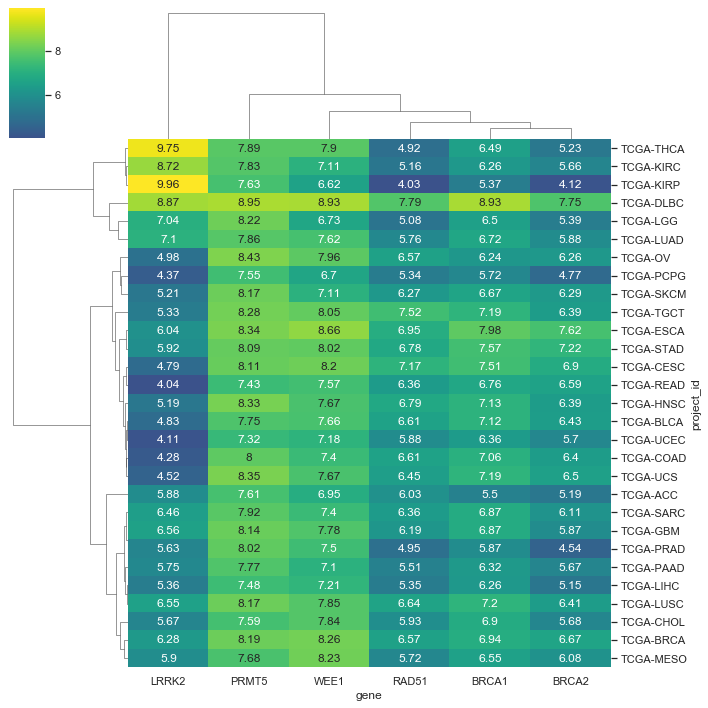

In [5]:
# cluster map of expression levels for Primary Tumor sample type
sample_type = 'Primary Tumor' # change this to visualize different sample types
cancer_df = df.loc[df['sample_type'] == sample_type]
foo = cancer_df.groupby(['project_id', 'gene'], as_index=False)['count'].median()
foo['count'] = foo['count'].apply(lambda x: round(pd.np.log(x), 2))

result = foo.pivot(index='project_id', columns='gene', values='count')
sns.clustermap(result, annot=True, fmt="g", cmap='viridis', center=6, metric="correlation")
plt.show()

<ipython-input-6-221c7bb10efd>:11: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  mask = pd.np.triu(pd.np.ones_like(corr_df, dtype=pd.np.bool))


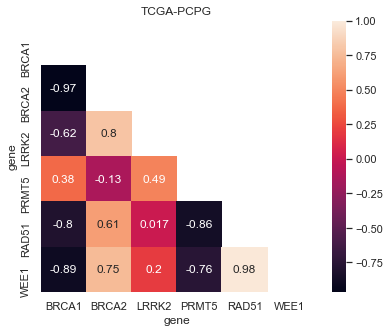

In [6]:
# corrolation of genes in cancer samples in different projects plotted as individual heatmaps
df1 = pd.pivot_table(
    df.loc[df['sample_type'] == 'Primary Tumor'],
    index=['project_id','sample_id'], 
    columns='gene',
    values='count', 
    fill_value=0
)
df1.reset_index(inplace=True)

for project in set(df['project_id']):
    temp_df = df1.loc[df1['project_id'] == project]
    # print(temp_df.corr(method='pearson'))
    corr_df = temp_df.corr(method='pearson')
    
    mask = pd.np.triu(pd.np.ones_like(corr_df, dtype=pd.np.bool))
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(7, 5))
        ax = sns.heatmap(corr_df, mask=mask, square=True, annot=True).set_title(project)
        
    break

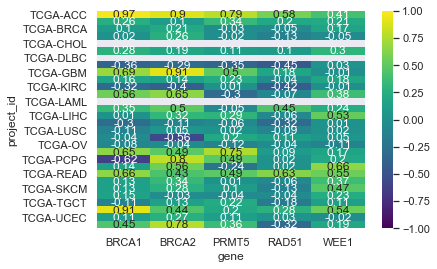

In [7]:
# show just genes correlations with LRRK2 in a heatmap
final_df = pd.DataFrame()
for project in set(df['project_id']):
    temp_df = df1.loc[df1['project_id'] == project]
    corr_df = temp_df.corr(method='pearson')
    corr_df['project_id'] = project
    corr_df.reset_index(inplace=True)
    corr_df = corr_df[['LRRK2', 'project_id', 'gene']]
    final_df = pd.concat([final_df, corr_df])

final_df['LRRK2'] = final_df['LRRK2'].apply(lambda x: round(x, 2))
piv_df = final_df.pivot(index='project_id', columns='gene', values='LRRK2')
piv_df.drop(['LRRK2'], axis=1, inplace=True)
sns.heatmap(piv_df, vmin=-1, vmax=1, annot=True, fmt="g", cmap='viridis')
plt.show()

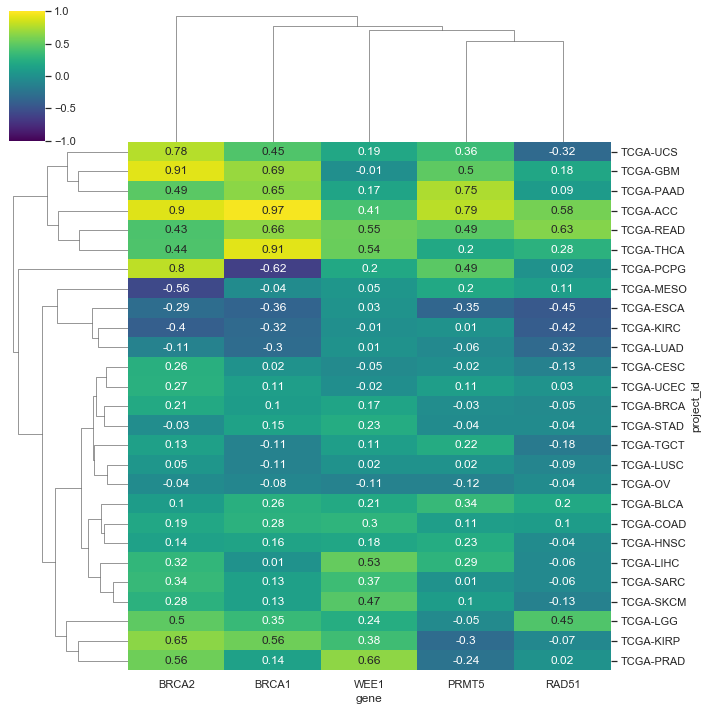

In [8]:
# cluster map for corrolation of genes with LRRK2 for every project in Primary Tumor sample type
piv_df.dropna(axis=0, inplace=True)
sns.clustermap(piv_df, vmin=-1, vmax=1, annot=True, fmt="g", cmap='viridis')
plt.show()